<a href="https://colab.research.google.com/github/llaroft/GenAI-Project/blob/main/GenAI_FinalAssigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 100
NOISE_DIM = 100
NUM_CLASSES = 10
IMAGE_SHAPE = (28, 28, 1)


In [ ]:

(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images / 127.5 - 1.0
train_images = train_images[..., tf.newaxis].astype("float32")

train_labels = tf.one_hot(train_labels, NUM_CLASSES)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(NOISE_DIM + NUM_CLASSES,)),
        layers.Dense(7 * 7 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [ ]:
# Discriminator
def build_discriminator():
    image_input = layers.Input(shape=IMAGE_SHAPE)
    label_input = layers.Input(shape=(NUM_CLASSES,))

    label_map = layers.Dense(np.prod(IMAGE_SHAPE))(label_input)
    label_map = layers.Reshape(IMAGE_SHAPE)(label_map)

    x = layers.Concatenate()([image_input, label_map])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    return tf.keras.Model([image_input, label_input], output)

In [ ]:
generator = build_generator()
discriminator = build_discriminator()

In [ ]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([tf.shape(images)[0], NOISE_DIM])
    gen_input = tf.concat([noise, labels], axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(gen_input, training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")
        generate_and_save_images(generator, epoch + 1)

In [ ]:

def generate_and_save_images(model, epoch):
    test_labels = tf.one_hot(tf.range(NUM_CLASSES), NUM_CLASSES)
    test_noise = tf.random.normal([NUM_CLASSES, NOISE_DIM])
    gen_input = tf.concat([test_noise, test_labels], axis=1)
    predictions = model(gen_input, training=False)

    fig = plt.figure(figsize=(10, 1))
    for i in range(predictions.shape[0]):
        plt.subplot(1, NUM_CLASSES, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

Epoch 1, Gen Loss: 0.7682, Disc Loss: 1.5540


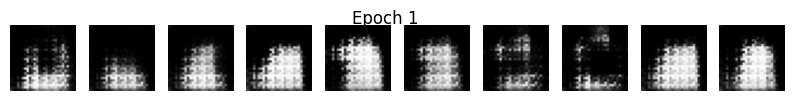

Epoch 2, Gen Loss: 0.9139, Disc Loss: 1.1972


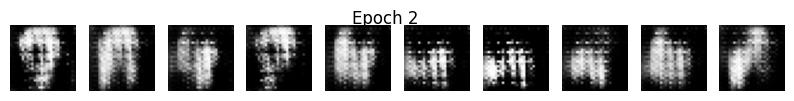

Epoch 3, Gen Loss: 0.9913, Disc Loss: 1.0967


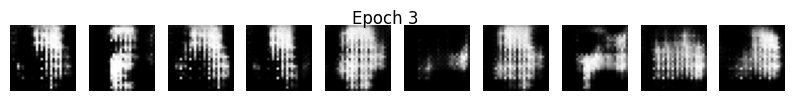

Epoch 4, Gen Loss: 0.9017, Disc Loss: 1.0871


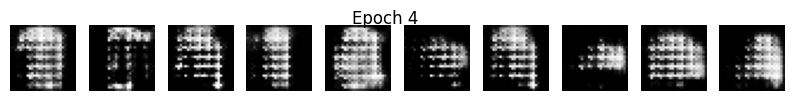

Epoch 5, Gen Loss: 0.9626, Disc Loss: 1.0004


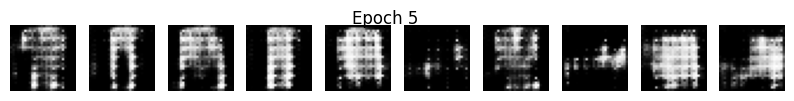

Epoch 6, Gen Loss: 0.9969, Disc Loss: 1.0967


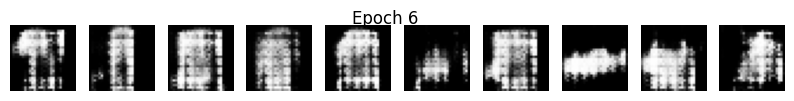

Epoch 7, Gen Loss: 1.3430, Disc Loss: 0.8162


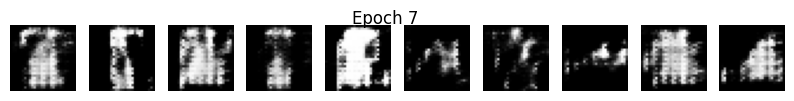

Epoch 8, Gen Loss: 1.3049, Disc Loss: 0.8414


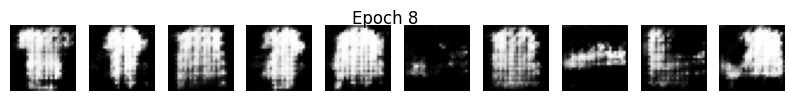

Epoch 9, Gen Loss: 0.8394, Disc Loss: 1.5180


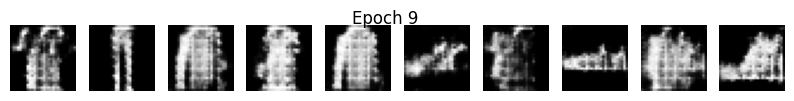

Epoch 10, Gen Loss: 1.1017, Disc Loss: 0.9919


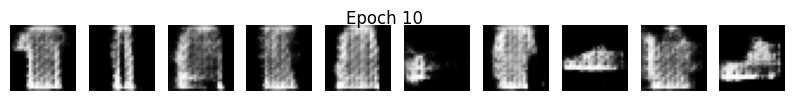

Epoch 11, Gen Loss: 1.3465, Disc Loss: 1.0708


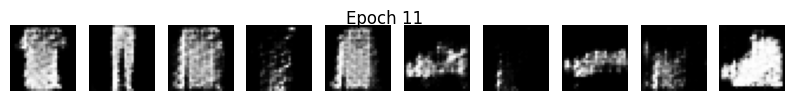

Epoch 12, Gen Loss: 1.4138, Disc Loss: 0.7897


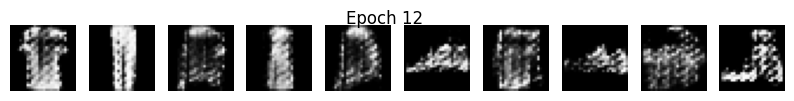

Epoch 13, Gen Loss: 1.4482, Disc Loss: 1.0195


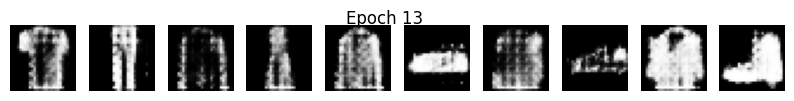

Epoch 14, Gen Loss: 1.3281, Disc Loss: 0.9199


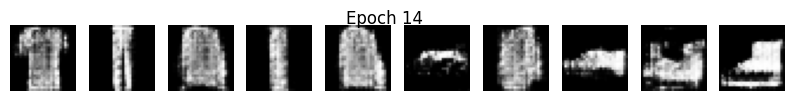

Epoch 15, Gen Loss: 1.2830, Disc Loss: 1.2461


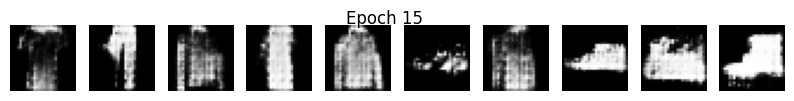

Epoch 16, Gen Loss: 1.5087, Disc Loss: 0.8461


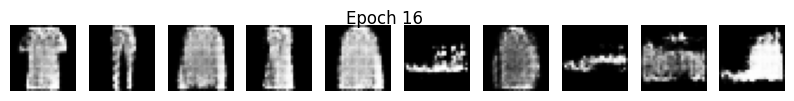

Epoch 17, Gen Loss: 1.2050, Disc Loss: 1.0074


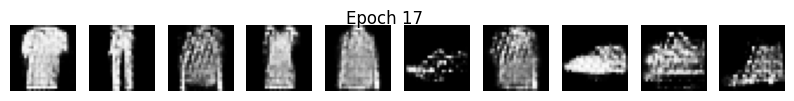

Epoch 18, Gen Loss: 1.3351, Disc Loss: 0.9805


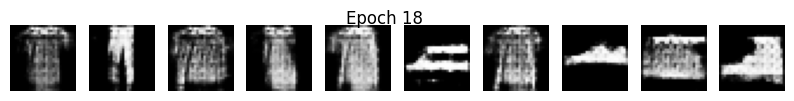

Epoch 19, Gen Loss: 1.4090, Disc Loss: 0.8040


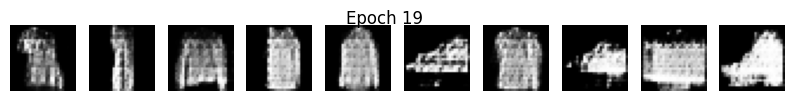

Epoch 20, Gen Loss: 1.3213, Disc Loss: 0.9615


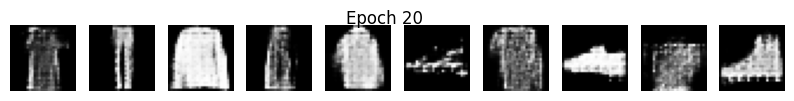

Epoch 21, Gen Loss: 1.3848, Disc Loss: 0.9620


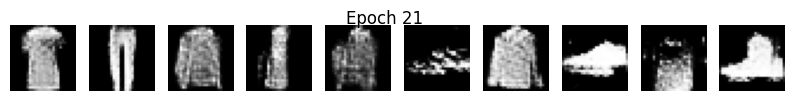

Epoch 22, Gen Loss: 1.1629, Disc Loss: 1.0654


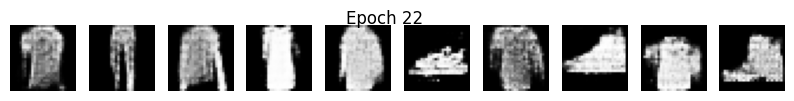

Epoch 23, Gen Loss: 1.3357, Disc Loss: 0.8980


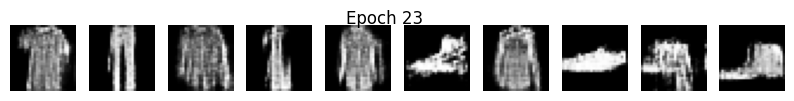

Epoch 24, Gen Loss: 1.6069, Disc Loss: 0.7929


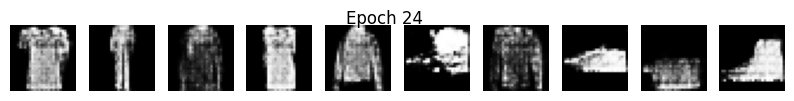

Epoch 25, Gen Loss: 1.4142, Disc Loss: 0.9239


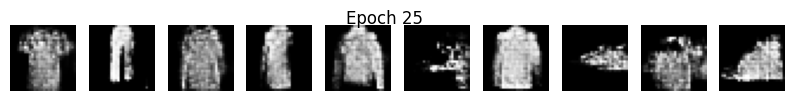

Epoch 26, Gen Loss: 1.3308, Disc Loss: 0.9879


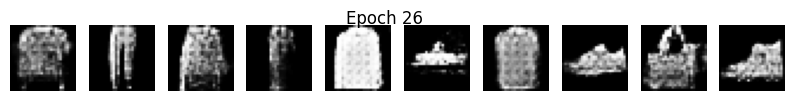

Epoch 27, Gen Loss: 1.3614, Disc Loss: 0.9446


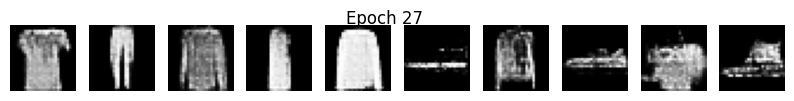

Epoch 28, Gen Loss: 1.3185, Disc Loss: 0.8800


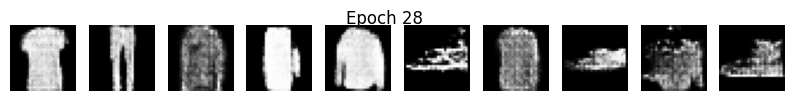

Epoch 29, Gen Loss: 1.4255, Disc Loss: 0.9303


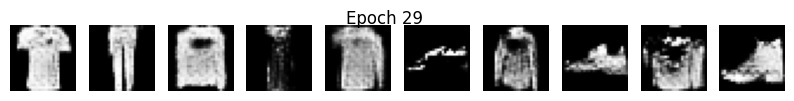

Epoch 30, Gen Loss: 1.0396, Disc Loss: 1.1641


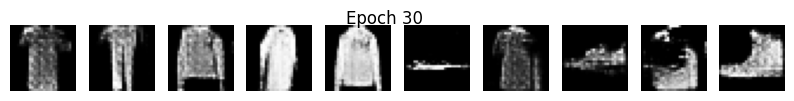

Epoch 31, Gen Loss: 1.3501, Disc Loss: 1.0075


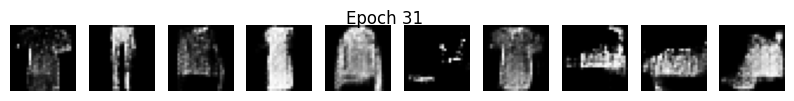

Epoch 32, Gen Loss: 1.3368, Disc Loss: 1.0423


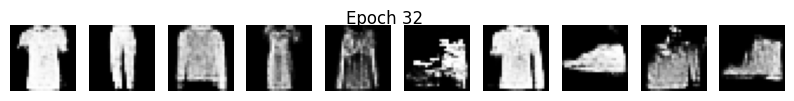

Epoch 33, Gen Loss: 1.4689, Disc Loss: 0.9880


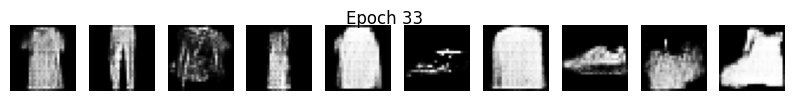

Epoch 34, Gen Loss: 1.3159, Disc Loss: 0.9033


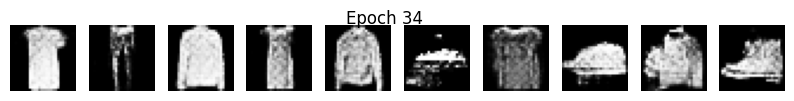

Epoch 35, Gen Loss: 1.5693, Disc Loss: 0.9425


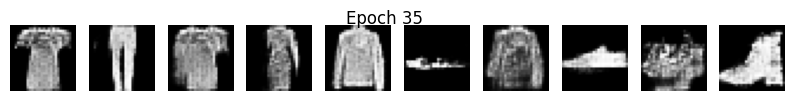

Epoch 36, Gen Loss: 1.2558, Disc Loss: 1.1468


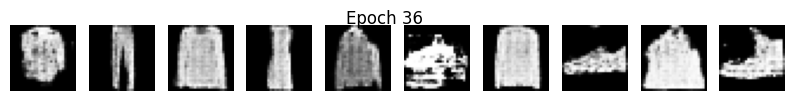

Epoch 37, Gen Loss: 1.2468, Disc Loss: 1.0258


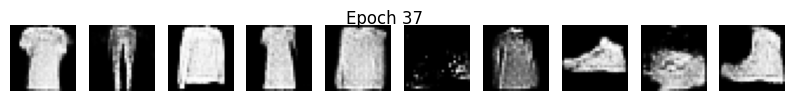

Epoch 38, Gen Loss: 1.2702, Disc Loss: 0.9681


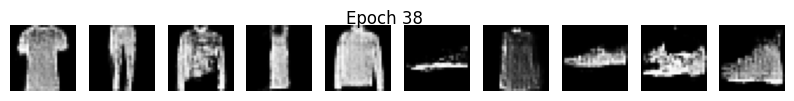

Epoch 39, Gen Loss: 1.1084, Disc Loss: 1.1928


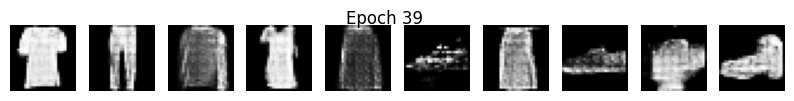

Epoch 40, Gen Loss: 1.1051, Disc Loss: 1.1756


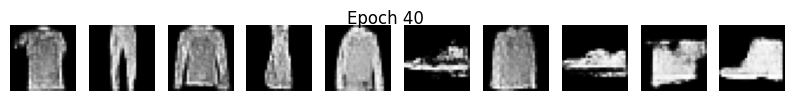

Epoch 41, Gen Loss: 1.1115, Disc Loss: 1.0369


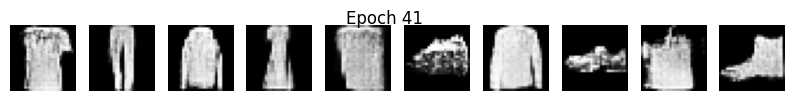

Epoch 42, Gen Loss: 1.2061, Disc Loss: 0.9335


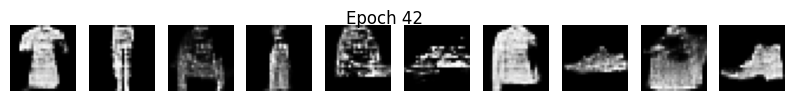

Epoch 43, Gen Loss: 1.1640, Disc Loss: 1.1732


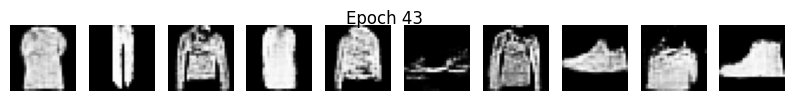

Epoch 44, Gen Loss: 1.1103, Disc Loss: 1.1324


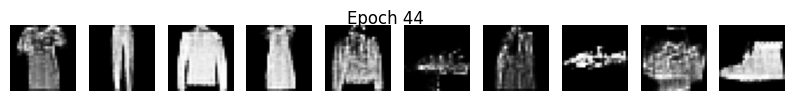

Epoch 45, Gen Loss: 1.0824, Disc Loss: 1.1343


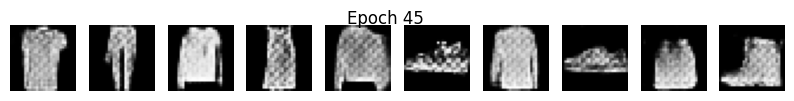

Epoch 46, Gen Loss: 1.0820, Disc Loss: 1.1359


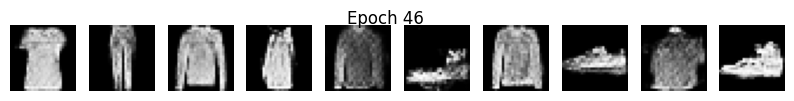

Epoch 47, Gen Loss: 0.9239, Disc Loss: 1.3225


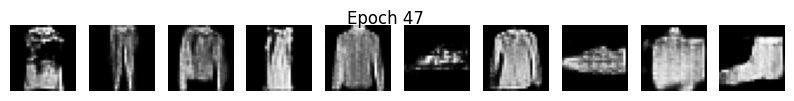

Epoch 48, Gen Loss: 1.0024, Disc Loss: 1.3109


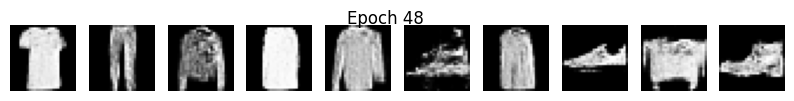

Epoch 49, Gen Loss: 1.1070, Disc Loss: 1.0368


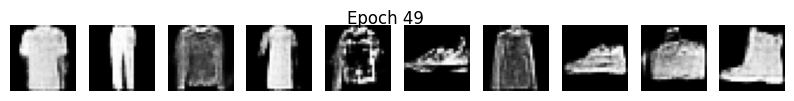

Epoch 50, Gen Loss: 0.9965, Disc Loss: 1.1845


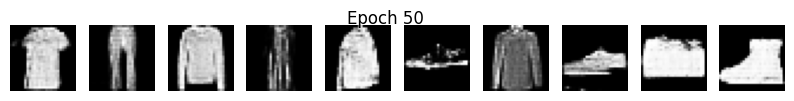

Epoch 51, Gen Loss: 1.1085, Disc Loss: 1.1512


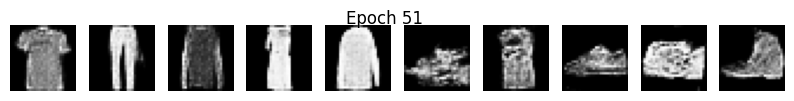

Epoch 52, Gen Loss: 1.0437, Disc Loss: 1.1765


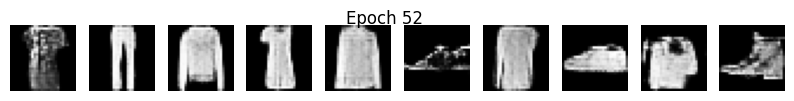

Epoch 53, Gen Loss: 0.9403, Disc Loss: 1.2611


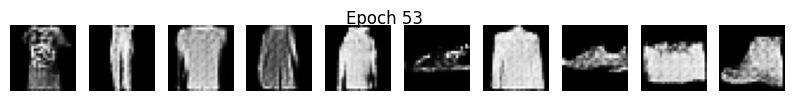

Epoch 54, Gen Loss: 1.0892, Disc Loss: 0.9488


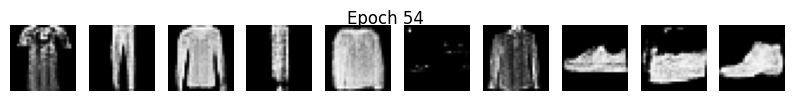

Epoch 55, Gen Loss: 1.1815, Disc Loss: 1.0464


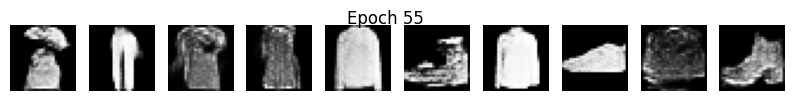

Epoch 56, Gen Loss: 0.9505, Disc Loss: 1.1923


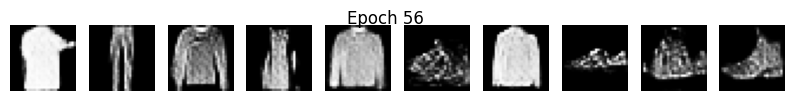

Epoch 57, Gen Loss: 0.9237, Disc Loss: 1.1192


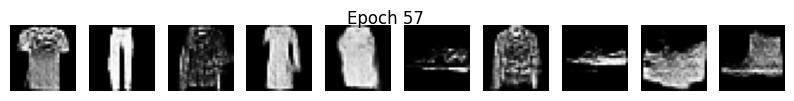

Epoch 58, Gen Loss: 1.0187, Disc Loss: 1.2103


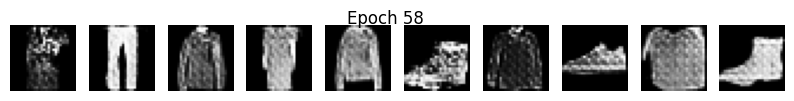

Epoch 59, Gen Loss: 1.1039, Disc Loss: 1.1231


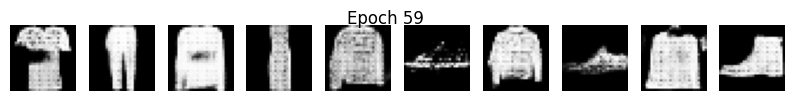

Epoch 60, Gen Loss: 1.0033, Disc Loss: 1.1837


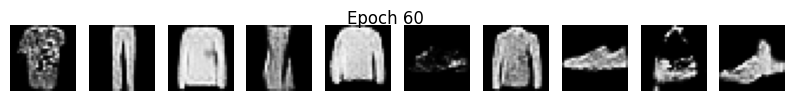

Epoch 61, Gen Loss: 1.0011, Disc Loss: 1.1921


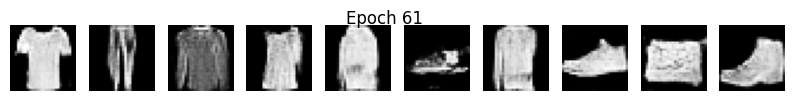

Epoch 62, Gen Loss: 0.9432, Disc Loss: 1.2189


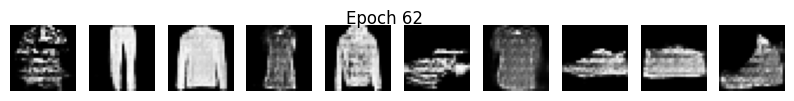

Epoch 63, Gen Loss: 1.1146, Disc Loss: 1.0796


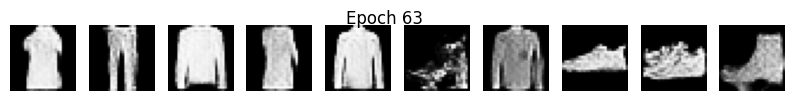

Epoch 64, Gen Loss: 0.9427, Disc Loss: 1.2597


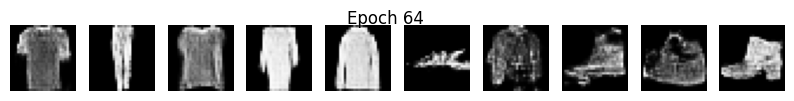

Epoch 65, Gen Loss: 1.2505, Disc Loss: 0.9970


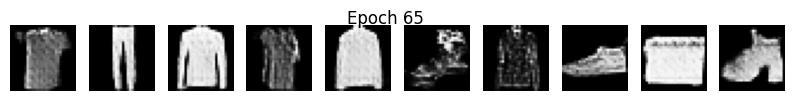

Epoch 66, Gen Loss: 1.0071, Disc Loss: 1.2151


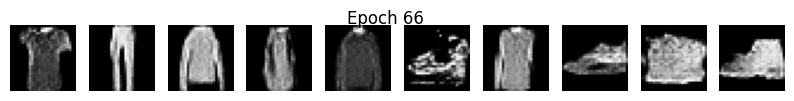

Epoch 67, Gen Loss: 1.0710, Disc Loss: 1.1345


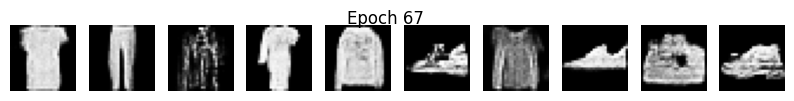

Epoch 68, Gen Loss: 0.9277, Disc Loss: 1.2625


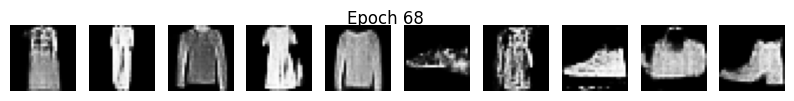

Epoch 69, Gen Loss: 1.1115, Disc Loss: 1.1752


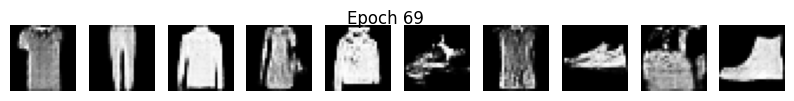

Epoch 70, Gen Loss: 0.9093, Disc Loss: 1.3105


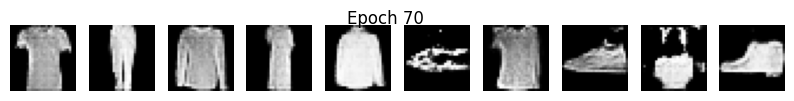

Epoch 71, Gen Loss: 0.9562, Disc Loss: 1.2963


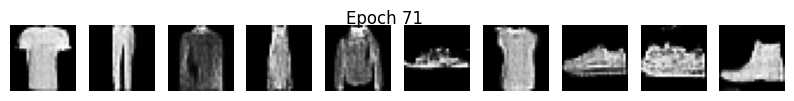

Epoch 72, Gen Loss: 1.0264, Disc Loss: 1.2092


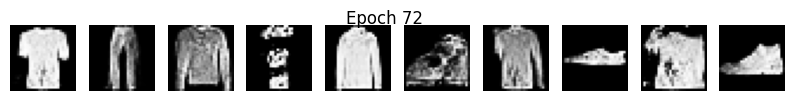

Epoch 73, Gen Loss: 0.9335, Disc Loss: 1.2573


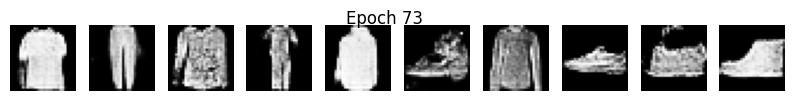

Epoch 74, Gen Loss: 0.9264, Disc Loss: 1.3190


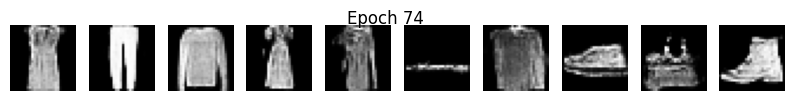

Epoch 75, Gen Loss: 0.9128, Disc Loss: 1.1926


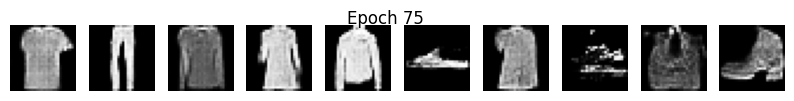

Epoch 76, Gen Loss: 1.3961, Disc Loss: 1.0802


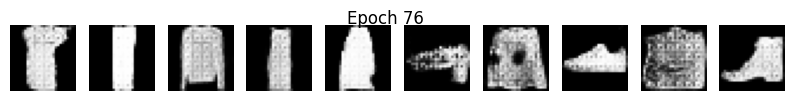

Epoch 77, Gen Loss: 0.7781, Disc Loss: 1.3930


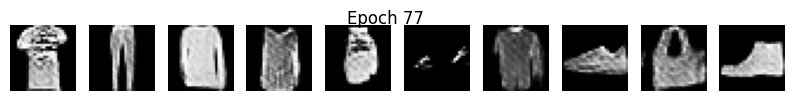

Epoch 78, Gen Loss: 0.9712, Disc Loss: 1.2682


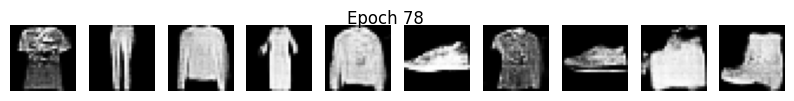

Epoch 79, Gen Loss: 0.9412, Disc Loss: 1.2648


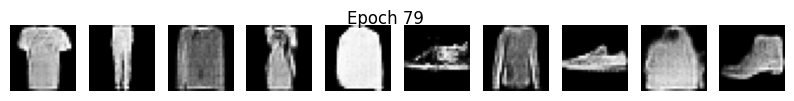

Epoch 80, Gen Loss: 0.9935, Disc Loss: 1.1222


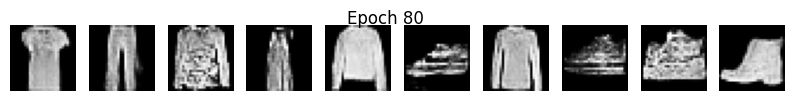

Epoch 81, Gen Loss: 0.8979, Disc Loss: 1.2272


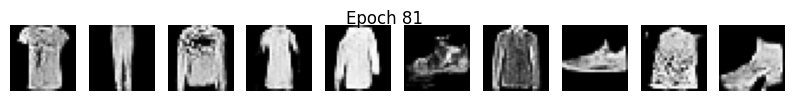

Epoch 82, Gen Loss: 0.9013, Disc Loss: 1.2091


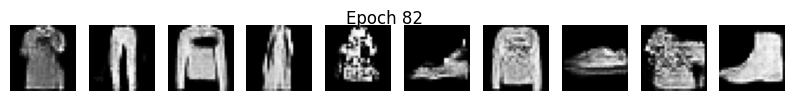

Epoch 83, Gen Loss: 0.9830, Disc Loss: 1.2061


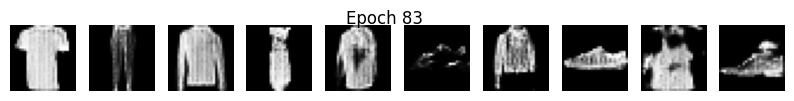

Epoch 84, Gen Loss: 0.9672, Disc Loss: 1.1807


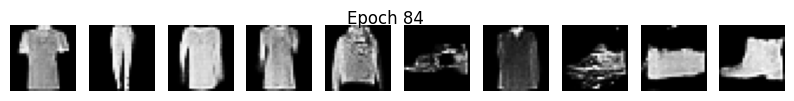

Epoch 85, Gen Loss: 0.9966, Disc Loss: 1.2660


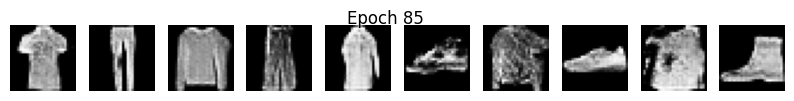

Epoch 86, Gen Loss: 0.7455, Disc Loss: 1.3727


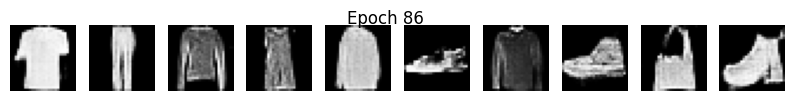

Epoch 87, Gen Loss: 0.9206, Disc Loss: 1.3220


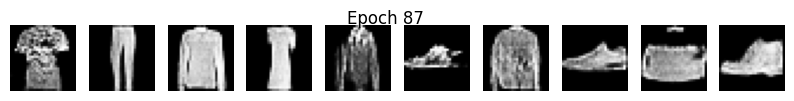

Epoch 88, Gen Loss: 1.0267, Disc Loss: 1.2024


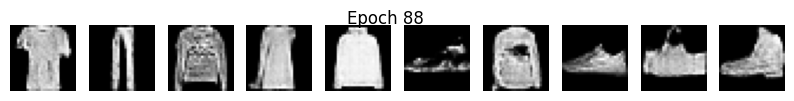

Epoch 89, Gen Loss: 0.8920, Disc Loss: 1.2957


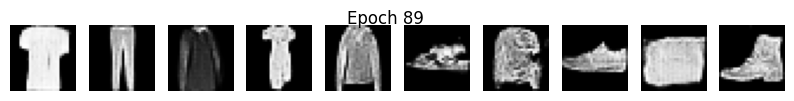

Epoch 90, Gen Loss: 0.8344, Disc Loss: 1.3067


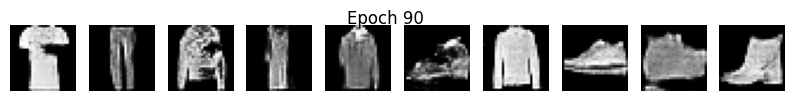

Epoch 91, Gen Loss: 0.8992, Disc Loss: 1.2074


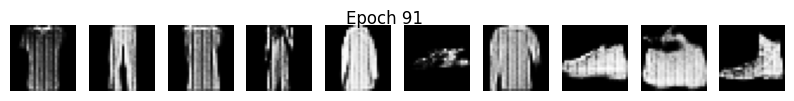

Epoch 92, Gen Loss: 1.0811, Disc Loss: 1.1666


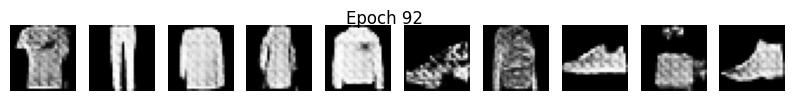

Epoch 93, Gen Loss: 1.0637, Disc Loss: 1.0767


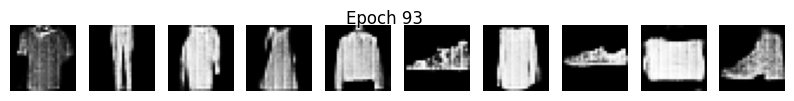

Epoch 94, Gen Loss: 1.0598, Disc Loss: 1.2269


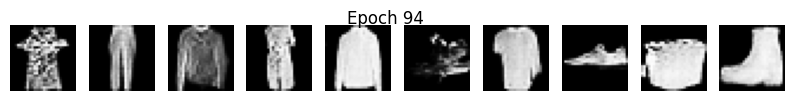

Epoch 95, Gen Loss: 0.8968, Disc Loss: 1.2806


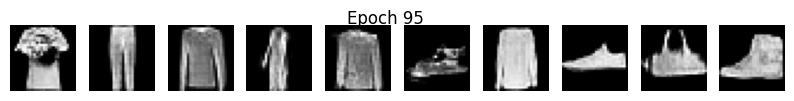

Epoch 96, Gen Loss: 1.0502, Disc Loss: 1.2400


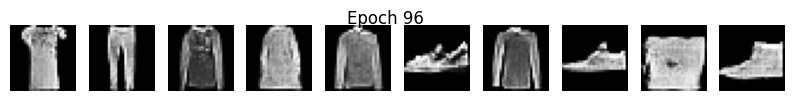

Epoch 97, Gen Loss: 0.9416, Disc Loss: 1.2037


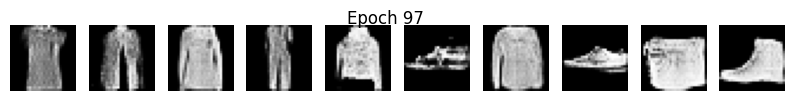

Epoch 98, Gen Loss: 0.9390, Disc Loss: 1.2528


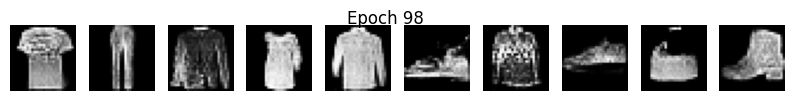

Epoch 99, Gen Loss: 0.8575, Disc Loss: 1.2076


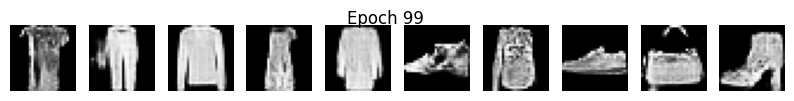

Epoch 100, Gen Loss: 0.8661, Disc Loss: 1.2696


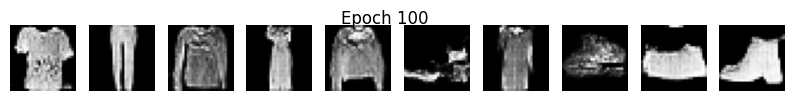

In [ ]:
#Start Training
train(train_dataset, EPOCHS)